In [ ]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
# import modules
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, ReLU
from keras import backend
from keras.callbacks import TensorBoard
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 

In [ ]:
# mounting Google Drive and setting path
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive/DS301 Final Project/data/'

Mounted at /content/drive


In [ ]:
# reading in data
X = pd.read_csv(path + "calls_data.csv")
y = pd.read_csv(path + "calls_target.csv")

# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initial Multilayer Perceptron

In [ ]:
# hyperparameters
n_units = 100
hidden_layers = 3 
batch_size = 1024
epochs = 10

# input layer
model = Sequential()
model.add(Dense(n_units, input_dim=X_train.shape[1]))
model.add(ReLU())

# hidden layers
for _ in range(hidden_layers):
    model.add(Dense(n_units))
    model.add(BatchNormalization())
    model.add(ReLU())

# output layer
model.add(Dense(1, activation='relu'))

optimizer = SGD()
model.compile(loss='mse', optimizer=optimizer)

In [ ]:
mlp1 = model.fit(X_train, 
                 y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 verbose=1)

Epoch 1/10
704/704 [==============================] - 22s 28ms/step - loss: 132663.0312 - val_loss: 197677.4688
Epoch 2/10
704/704 [==============================] - 15s 21ms/step - loss: 198117.2031 - val_loss: 197677.4688
Epoch 3/10
704/704 [==============================] - 12s 17ms/step - loss: 198117.3281 - val_loss: 197677.4688
Epoch 4/10
704/704 [==============================] - 12s 17ms/step - loss: 198117.5938 - val_loss: 197677.4688
Epoch 5/10
704/704 [==============================] - 12s 17ms/step - loss: 198117.4375 - val_loss: 197677.4688
Epoch 6/10
704/704 [==============================] - 13s 18ms/step - loss: 198117.3438 - val_loss: 197677.4688
Epoch 7/10
704/704 [==============================] - 12s 18ms/step - loss: 198117.3438 - val_loss: 197677.4688
Epoch 8/10
704/704 [==============================] - 12s 18ms/step - loss: 198117.5469 - val_loss: 197677.4688
Epoch 9/10
704/704 [==============================] - 12s 17ms/step - loss: 198117.2031 - val_loss: 1976

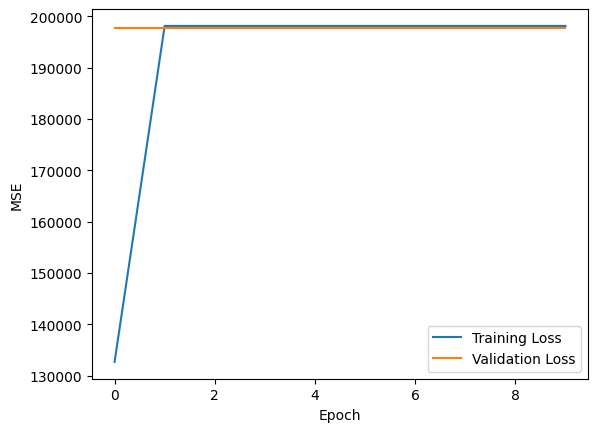

In [ ]:
plt.plot(mlp1.history['loss'])
plt.plot(mlp1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

6253/6253 [==============================] - 13s 2ms/step - loss: 198569.4531


198569.453125

# Hyperparameter Optimization

In [ ]:
def model_builder(hp):
  model = Sequential()

  # hyperparameters in search space
  hp_units = hp.Int('units', min_value=100, max_value=500, step=100)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'softmax'])
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

  model.add(Dense(hp_units, input_dim=X_train.shape[1]))
  
  # activation function
  if hp_activation == 'relu':
    activation_function = tf.keras.layers.ReLU()
  elif hp_activation == 'leaky_relu':
    activation_function = tf.keras.layers.LeakyReLU()
  elif hp_activation == 'softmax':
    activation_function = tf.keras.layers.Softmax()
  model.add(activation_function)
  for _ in range(3):
    model.add(Dense(n_units))
    model.add(activation_function)

  # output layer
  model.add(Dense(1, activation='relu'))

  # optimizer
  optimizer = Adam(learning_rate=hp_learning_rate)
  if hp_optimizer  == 'adam':
    optimizer = Adam(learning_rate=hp_learning_rate)
  if hp_optimizer  == 'sgd':
    optimizer = SGD(learning_rate=hp_learning_rate)
  if hp_optimizer  == 'rmsprop':
    optimizer = RMSprop(learning_rate=hp_learning_rate)
  model.compile(loss='mse', optimizer=hp_optimizer)

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hp_tuning',
                     project_name='mlp_call')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 500, 'step': 100, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu', 'softmax'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}


In [ ]:
tuner.search(X_train, y_train, epochs=5, validation_split=0.1, callbacks=[stop_early])

Trial 26 Complete [00h 08m 33s]
val_loss: 197677.578125

Best val_loss So Far: 82160.71875
Total elapsed time: 02h 05m 54s


In [ ]:
# get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('Number of hidden units: ', best_hps.get('units'))
print('Learning rate         : ', best_hps.get('learning_rate'))
print('Activation function   : ', best_hps.get('activation'))
print('Optimizer             : ', best_hps.get('optimizer'))

Number of hidden units:  500
Learning rate         :  0.01
Activation function   :  softmax
Optimizer             :  sgd


In [ ]:
# build model with optimal hyperparameters and train it  
model = tuner.hypermodel.build(best_hps)
mlp2 = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
20009/20009 [==============================] - 83s 4ms/step - loss: 198171.1719 - val_loss: 197684.2344
Epoch 2/50
20009/20009 [==============================] - 78s 4ms/step - loss: 198170.9688 - val_loss: 197684.2344
Epoch 3/50
20009/20009 [==============================] - 78s 4ms/step - loss: 198170.6562 - val_loss: 197684.2344
Epoch 4/50
20009/20009 [==============================] - 77s 4ms/step - loss: 198171.0625 - val_loss: 197684.2344
Epoch 5/50
20009/20009 [==============================] - 77s 4ms/step - loss: 198171.3594 - val_loss: 197684.2344
Epoch 6/50
20009/20009 [==============================] - 81s 4ms/step - loss: 198170.7656 - val_loss: 197684.2344
Epoch 7/50
20009/20009 [==============================] - 77s 4ms/step - loss: 198170.4062 - val_loss: 197684.2344
Epoch 8/50
20009/20009 [==============================] - 78s 4ms/step - loss: 198170.7188 - val_loss: 197684.2344
Epoch 9/50
20009/20009 [==============================] - 80s 4ms/step - loss: 1

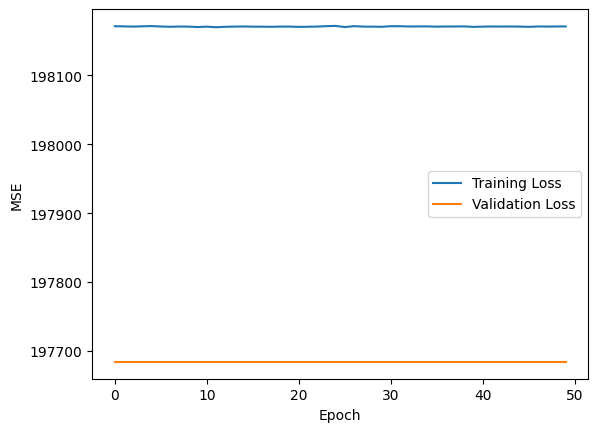

In [ ]:
plt.plot(mlp2.history['loss'])
plt.plot(mlp2.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
losses = mlp2.history['loss']
best_epochs = losses.index(min(losses))
best_epochs

11

In [ ]:
# re-build model and train it with the optimal number of epochs
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=best_epochs, validation_split=0.2)

Epoch 1/11
20009/20009 [==============================] - 81s 4ms/step - loss: 82471.4531 - val_loss: 82292.8203
Epoch 2/11
20009/20009 [==============================] - 82s 4ms/step - loss: 82334.3672 - val_loss: 82299.0469
Epoch 3/11
20009/20009 [==============================] - 82s 4ms/step - loss: 82332.7422 - val_loss: 82327.7422
Epoch 4/11
20009/20009 [==============================] - 81s 4ms/step - loss: 82331.8359 - val_loss: 82447.0781
Epoch 5/11
20009/20009 [==============================] - 84s 4ms/step - loss: 82330.5938 - val_loss: 82301.2969
Epoch 6/11
20009/20009 [==============================] - 78s 4ms/step - loss: 82333.5156 - val_loss: 82496.9453
Epoch 7/11
20009/20009 [==============================] - 79s 4ms/step - loss: 82331.7500 - val_loss: 82380.0469
Epoch 8/11
20009/20009 [==============================] - 79s 4ms/step - loss: 82336.5469 - val_loss: 82308.8359
Epoch 9/11
20009/20009 [==============================] - 81s 4ms/step - loss: 82336.3438 - val_

In [ ]:
model.evaluate(X_test, y_test)

6253/6253 [==============================] - 12s 2ms/step - loss: 82229.3516


82229.3515625

# Final MLP Model

In [ ]:
# hyperparameters
n_units = 500
hidden_layers = 3 
batch_size = 4096
epochs = 11

# input layer
model = Sequential()
model.add(Dense(n_units, input_dim=X_train.shape[1]))
model.add(LeakyReLU())

# hidden layers
for _ in range(hidden_layers):
    model.add(Dense(n_units))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

# output layer
model.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               15000     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 batch_normalization (BatchN  (None, 500)              2000      
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                        

In [ ]:
mlp3 = model.fit(X_train, 
                 y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 verbose=1)

Epoch 1/11
176/176 [==============================] - 94s 526ms/step - loss: 39925.1914 - val_loss: 31682.7344
Epoch 2/11
176/176 [==============================] - 88s 500ms/step - loss: 1865.0803 - val_loss: 54165.6797
Epoch 3/11
176/176 [==============================] - 88s 503ms/step - loss: 1665.0181 - val_loss: 11217.1602
Epoch 4/11
176/176 [==============================] - 88s 498ms/step - loss: 1487.5387 - val_loss: 5028.7925
Epoch 5/11
176/176 [==============================] - 92s 521ms/step - loss: 1238.4805 - val_loss: 8307.1660
Epoch 6/11
176/176 [==============================] - 89s 509ms/step - loss: 1183.7218 - val_loss: 3582.5305
Epoch 7/11
176/176 [==============================] - 89s 503ms/step - loss: 1229.9120 - val_loss: 42161.4258
Epoch 8/11
176/176 [==============================] - 88s 500ms/step - loss: 1208.8898 - val_loss: 11121.2812
Epoch 9/11
176/176 [==============================] - 101s 572ms/step - loss: 1131.8347 - val_loss: 3047.2793
Epoch 10/11


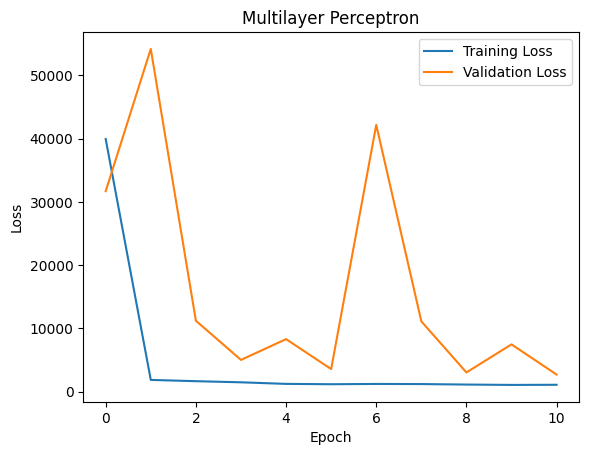

In [ ]:
plt.plot(mlp3.history['loss'])
plt.plot(mlp3.history['val_loss'])
plt.title('Multilayer Perceptron')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

6236/6236 [==============================] - 28s 5ms/step - loss: 2693.9043


2693.904296875

In [ ]:
model.save('drive/MyDrive/DS301 Final Project/models/mlp_calls')

# Retraining Model for Puts

In [ ]:
# reading in data
X = pd.read_csv(path + "puts_data.csv")
y = pd.read_csv(path + "puts_target.csv")

# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# hyperparameters
n_units = 500
hidden_layers = 3 
batch_size = 1024
epochs = 8

# input layer
model = Sequential()
model.add(Dense(n_units, input_dim=X_train.shape[1]))
model.add(LeakyReLU())

# hidden layers
for _ in range(hidden_layers):
    model.add(Dense(n_units))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

# output layer
model.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimizer)

In [ ]:
mlp4 = model.fit(X_train, 
                 y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 verbose=1)

Epoch 1/8
704/704 [==============================] - 91s 128ms/step - loss: 2560.8933 - val_loss: 21750.9434
Epoch 2/8
704/704 [==============================] - 90s 128ms/step - loss: 1086.6466 - val_loss: 20449.0742
Epoch 3/8
704/704 [==============================] - 95s 135ms/step - loss: 1107.0337 - val_loss: 54853.2305
Epoch 4/8
704/704 [==============================] - 89s 127ms/step - loss: 1037.4330 - val_loss: 54853.2383
Epoch 5/8
704/704 [==============================] - 90s 128ms/step - loss: 992.8270 - val_loss: 353013.6875
Epoch 6/8
704/704 [==============================] - 90s 128ms/step - loss: 1014.6676 - val_loss: 57920.7031
Epoch 7/8
704/704 [==============================] - 90s 127ms/step - loss: 1127.5670 - val_loss: 36405.3867
Epoch 8/8
704/704 [==============================] - 90s 128ms/step - loss: 1042.2697 - val_loss: 54855.7461


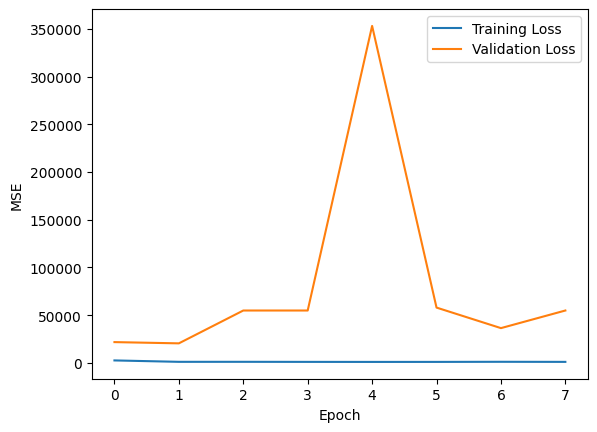

In [ ]:
plt.plot(mlp4.history['loss'])
plt.plot(mlp4.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

6253/6253 [==============================] - 24s 4ms/step - loss: 54958.2148


54958.21484375

In [ ]:
model.save('drive/MyDrive/DS301 Final Project/models/mlp_puts')